<a href="https://colab.research.google.com/github/Polinia/skillfactory_rds/blob/main/graduate_project_skillfactory_pr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification of Real / Fake Job Posting using Transformers**

Этот набор данных содержит 18.000 описаний вакансий, из которых около 800 - поддельные. Данные состоят из текстовой информации и другую дополнительную информацию о вакансиях. Набор данных буду использовать для создания моделей классификации, которые могут изучить мошеннические описания должностных обязанностей.

Задача - обучить модель классифицировать вакансии как реальные или мошеннические.

In [10]:
!pip install transformers -q
# !pip install --upgrade tensorflow -q
!pip install bert-tokenizer -q
!pip install shap -q
!pip install catboost -q

In [11]:
#Importing Libraries
import numpy as np 
import pandas as pd 
import pandas_profiling
import string
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.close('all')

import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from catboost import *
import shap 
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers.schedules import *
from transformers import BertTokenizer, TFBertModel, BertConfig,  BertTokenizerFast
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, Bidirectional, Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
# from tensorflow.keras.utils import to_categorical
from nltk.tokenize import RegexpTokenizer
import transformers
from transformers import DistilBertTokenizerFast, DistilBertModel, DistilBertConfig
import nltk
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

from imblearn.combine import SMOTETomek

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_tokenizer=RegexpTokenizer(r"\w+")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
pd.set_option('display.max_columns', None)

In [13]:
# Напишу функцию для воспроизведения графиков:
def plot_image(x,y):
    plt.title(x)
    plt.xlabel('index')
    plt.ylabel('percentage of fraudulent')
    plt.bar(np.array(y.index,dtype='str'),y)
    return plt.show()  

In [14]:
df = pd.read_csv('fake_job_postings.csv')
df.head(1)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0


Definition of the variables:

* job_id- Identification number given to each job posting  
* title - A name that describes the position or job 
* location - Information about where the job is located 
* department - Information about the department this job is offered by
* salary_range - Expected salary range 
* company_profile - Information about the company  
* description - A brief description about the position offered 
* requirements - Pre-requisites to qualify for the job 
* benefits - Benefits provided by the job 
* telecommuting - Is work from home or remote work allowed 
* has_company_logo - Does the job posting have a company logo 
* has_questions - Does the job posting have any questions 
* employment_type - 5 categories (Full-time, part-time, contract, temporary and other)
* required_experience - Can be: Internship, Entry Level, Associate, Mid-senior level, Director, Executive or Not Applicable 
* required_education - Can be: Bachelor’s degree, high school degree, unspecified, associate degree, master’s degree, certification, some college coursework, professional, some high school coursework, vocational  
* Industry - The industry the job posting is relevant to 
* Function - The umbrella term to determining a job’s functionality 
* Fraudulent - The target variable (0: Real, 1: Fake)

Проведем первичный осмотр:

In [15]:
# pandas_profiling.ProfileReport(df)

In [16]:
df.info()

df.isnull().sum() #пропущенные значения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

В данном датасете - 17880 объявлений и 18 признаков. Из числовых telecommuting, has_company_logo, has_questions. Остальные типа object. Целевая переменная у нас 'fraudulent'. Так же в датасете имеются пропуски.        

In [17]:
#проверка на дупликаты
df['job_id'].duplicated().sum()

0

In [18]:
bin_cols = ['telecommuting', 'has_company_logo', 'has_questions']
cat_cols = ['department', 'employment_type', 'required_experience', 
                'required_education', 'industry', 'function']
text_cols = ['title', 'location','company_profile', 'description', 'requirements', 'benefits']

In [19]:
for col in text_cols:
    df[col].fillna(' ', inplace=True)
for col in cat_cols:
  df[col].fillna("Unspecified", inplace=True)

**Baseline**

Построим "наивную"/baseline модель (с ней будем сравнивать изменения в датасете и другие модели)

In [20]:
#сразу избавлюсь от job.id,он больше не нужен
df.drop('job_id', axis=1, inplace=True)

**Salary Range**

сделаю парсинг чисел из значений признака salary_range

In [21]:
df['salary_range'].fillna("Unspecified", inplace=True)
df.salary_range.value_counts()

Unspecified      15012
0-0                142
40000-50000         66
30000-40000         55
45000-67000         37
                 ...  
400000-500000        1
120000-135000        1
15-25                1
130000-170000        1
192000-288000        1
Name: salary_range, Length: 875, dtype: int64

Достаточно большой представлен диапазон зарплат

In [22]:
salary_range = df.salary_range
salary_range.head(12)

0       Unspecified
1       Unspecified
2       Unspecified
3       Unspecified
4       Unspecified
5       Unspecified
6       20000-28000
7       Unspecified
8       Unspecified
9       Unspecified
10    100000-120000
11      Unspecified
Name: salary_range, dtype: object

Имеется очень много пропущенных значений,а имеющиеся значения преобразуем в max и min

In [23]:
#Заменим пустые значения на 0-0
salary_range.replace('Unspecified','0-0', inplace=True)
salary_range.head(12)

0               0-0
1               0-0
2               0-0
3               0-0
4               0-0
5               0-0
6       20000-28000
7               0-0
8               0-0
9               0-0
10    100000-120000
11              0-0
Name: salary_range, dtype: object

In [24]:
#Разделим теперь значения
salary_range_sep = list(salary_range.str.split('-').values)
salary_range_sep[:5]

[['0', '0'], ['0', '0'], ['0', '0'], ['0', '0'], ['0', '0']]

In [25]:
#Проверим,возможно есть необычные значения:
for x, y in enumerate(salary_range_sep):
    if len(y) < 2 or len(y) > 2:
        print(x, y)

5538 ['40000']


In [26]:
#Замена значения
salary_range_sep[5538] = ['40000', '40000']

In [27]:
#Проверим какие еще значения у нас имеются в этом признаке
error_range_inds = []
for range_ind, s_range in enumerate(salary_range_sep):
    min_value, max_value = s_range
    if not min_value.isdigit() or not max_value.isdigit():
        print(range_ind, (min_value, max_value))
        error_range_inds += [range_ind]

159 ('9', 'Dec')
1884 ('3', 'Apr')
1981 ('4', 'Apr')
2313 ('Oct', '15')
4299 ('8', 'Sep')
9124 ('4', 'Jun')
9902 ('10', 'Oct')
9911 ('Oct', '20')
10316 ('Jun', '18')
10785 ('10', 'Oct')
10788 ('11', 'Nov')
10860 ('10', 'Nov')
10883 ('10', 'Oct')
10889 ('10', 'Nov')
10896 ('10', 'Oct')
10905 ('10', 'Nov')
11361 ('11', 'Dec')
11495 ('2', 'Apr')
11606 ('10', 'Nov')
12421 ('10', 'Oct')
13449 ('11', 'Nov')
13482 ('2', 'Jun')
14196 ('Oct', '20')
15483 ('10', 'Oct')
17233 ('10', 'Nov')
17656 ('Dec', '25')


И заметим,что в некоторых вакансиях почему-то указаны даты вместо заплаты. Исправлю это заменив на 0

In [28]:
for range_ind in error_range_inds:
    salary_range_sep[range_ind] = ['0', '0']
df_salary_range = pd.DataFrame(np.array(salary_range_sep, dtype='int64'), 
                                 columns=['min_salary', 'max_salary'])
df_salary_range.head(11)

,min_salary,max_salary
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,20000,28000
7,0,0
8,0,0
9,0,0


In [29]:
df['min_salary'] = df_salary_range['min_salary']
df['max_salary'] = df_salary_range['max_salary']

#создам дополнительный признак, указывающий на присутствие зп
df['salary_specified'] = ((df.min_salary != 0) | 
                                         (df.max_salary != 0)).astype('int64')

In [30]:
bin_cols.append('salary_specified')
df.drop('salary_range', axis=1, inplace=True) #удалю этот признак так как он больше не нужен

In [31]:
df.head(1)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary,salary_specified
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,Unspecified,Unspecified,Marketing,0,0,0,0


In [28]:
   #Сделаю функцию для дальнейшего вызова кросс-валидации на 5 фолдах:
def Catboostcl(X,y,cat_features,text_features):

  cv = KFold(n_splits = 5, random_state=42, shuffle=True)
  global model
  scores = []
  for train_index, test_index in cv.split(X):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      #Сбалансирую таргет:
      sample_weight= np.array(y_train.apply( lambda x: 1/19.6 if x==1 else 1))

      model = CatBoostClassifier(iterations=200,
                             verbose=False,
                             loss_function='Logloss',
                             eval_metric = 'F1',
                             cat_features=cat_features, #определили и передали категориальные признаки
                             text_features=text_features  #определили и передали текстовые признаки
                             ).fit(X_train, y_train, eval_set=(X_test, y_test),
                             sample_weight=sample_weight,      
                             use_best_model=True,)

    # сделаем предсказание
      preds = model.predict(X_test)
      score = f1_score(y_test, preds)
      scores.append(score)
# оценим итоги. Взглянем на усредненное значение метрики по блокам
  print(f'MEAN F1: {np.mean(scores) * 100:.2f}%')

In [29]:
#попробуйю удалить признак и посмотреть на точность
X = df.drop(['fraudulent'], axis=1).fillna(0).values
y = df['fraudulent']
cat_features = list(range(10,15))
text_features = list(range(0,7))
Catboostcl(X,y,cat_features,text_features)

MEAN F1: 40.02%


Оценка важности признаков:

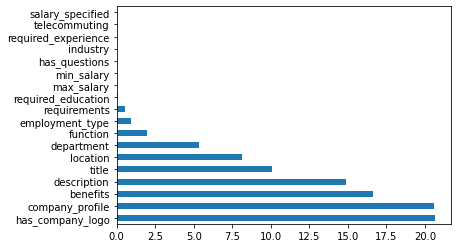

In [30]:
def feat_importance(data3):
  X = data3.drop(['fraudulent'], axis=1).fillna(0)
  feat_importances = pd.Series(model.feature_importances_, index=X.columns)
  feat_importances.nlargest(20).plot(kind='barh')
feat_importance(df)

Судя по графику,можно сделать вывод,что признак 'company profile' имеет очень большое вляние на целевую переменную,поэтому имеет смысл избавится от него

проделав работу над бейзлайном, мы:

* получили базовое значение метрики качества, с которым будем далее сравнивать изменения в датасете и которое будем стараться улучшить. 
* получили предварительную информацию о важности признаков.

# EDA

In [32]:
df.head(1)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary,salary_specified
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,Unspecified,Unspecified,Marketing,0,0,0,0


In [33]:
#подготовлю сразу описание,совмещающее в себе сразу все текстовые признаки для работы с BERToм
data =  df['title'] + " " + df['department'] + \
             " " + df['company_profile'] + " " + \
             df['description'] + " " + \
             df['requirements'] + " " +\
             df['benefits'] + " " +\
             df['function'] + " " \

In [34]:
# Соеденю с целевой переменной в один DF
df1=df['fraudulent'] 
data = pd.concat([data,df1], axis=1)
data.columns = ['text', 'fraudulent']

In [35]:
data.isnull().sum()

text          0
fraudulent    0
dtype: int64

Рассмотрю теперь каждый признак отдельно:

**Telecommuting**

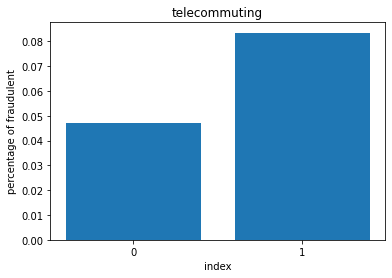

In [35]:
frad_telecom = df.groupby('telecommuting').mean()['fraudulent']
plot_image('telecommuting',frad_telecom)

На графике видно,что вакансии,которые обещают работу с дома, имеют практически в 2 раза больше вероятность мошенничества. 

**Company Logo**

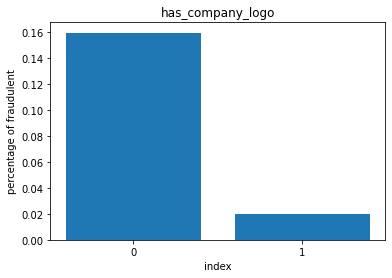

In [36]:
fraud_logo=df.groupby('has_company_logo').mean()['fraudulent']
plot_image('has_company_logo',fraud_logo)

Вакансии, в которых компании без фирменного логотипа, имеют в 8 раз больше вероятность оказаться мошенническими.

In [37]:
#попробуйю удалить признак и посмотреть на точность
X = df.drop(['fraudulent','has_company_logo'], axis=1).fillna(0).values
y = df['fraudulent']
cat_features = list(range(9, 14))
text_features = list(range(0,7))
Catboostcl(X,y,cat_features,text_features)

MEAN F1: 41.18%


In [36]:
df.drop(['has_company_logo'], axis=1,inplace=True)

метрика улучшилась,но не на много. Проведу эксперименты в конце и посмотрю,стоит ли удалять

**Has Question**

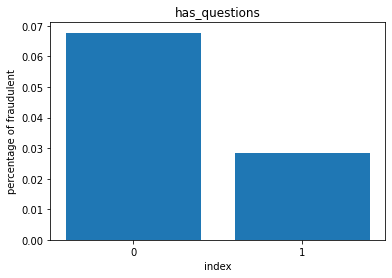

In [39]:
fraud_question = df.groupby('has_questions').mean()['fraudulent']
plot_image('has_questions',fraud_question)

Вакансии, в которых нет вопросов к соискателю, имеют в 3 раза больше вероятность оказаться мошенническими. Отсюда вывод - мошенники не добавляют проверочные вопросы.

**Employment Type**

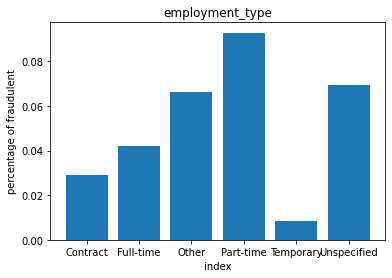

In [40]:
fraud_type = df.groupby('employment_type').mean()['fraudulent']
plot_image('employment_type',fraud_type)

Part-time (частичная занятость) работы имеют самый высокий процент (почти 10%) мошенничества. На втором месте вакансии,где не указан тип работы, то есть возможно мошенники не вдаются в подробности вакансии

**Required Education**

In [41]:
df.required_education.value_counts()

Unspecified                          9502
Bachelor's Degree                    5145
High School or equivalent            2080
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

index 1: Associate Degree, index 2: Bachelor's Degree, index 3: Certification, index 4: Doctorate, index 5: High School or equivalent, index 6: Master's Degree, index 7: Professional, index 8: Some College Coursework Completed, index 9: Some High School Coursework, index 10: Unspecified, index 11: Vocational, index 12: Vocational - Degree, index 13: Vocational - HS Diploma, 

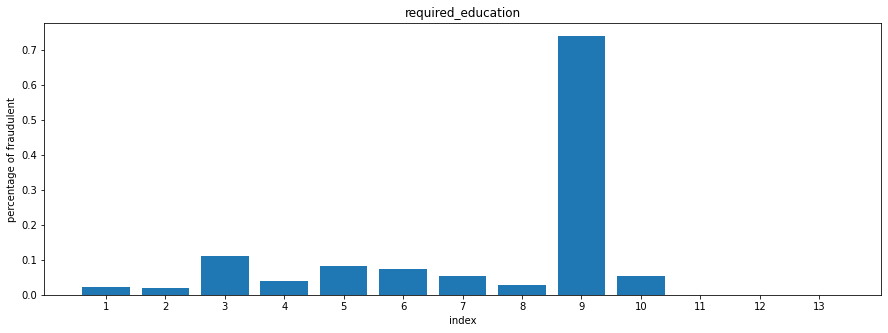

In [42]:
fraud_educ = df.groupby('required_education').mean()['fraudulent']
for k,l in enumerate(np.array(fraud_educ.index,dtype='str')):
    print(f'index {k+1}: {l}',end=", ")
    
plt.figure(figsize=(15,5))
plt.title('required_education')
plt.xlabel('index')
plt.ylabel('percentage of fraudulent')
plt.xticks(np.arange(1,len(fraud_educ)+1,1))
plt.bar(np.arange(1,len(fraud_educ)+1,1),fraud_educ)
plt.show()

Очень заметно,что вакансии, где указано требование "Some High School Coursework" (незаконченное среднее образование) являются нереальными (примерно 70%). Кстати, сертификаты тоже имеют большой процент - около 10%.  Похоже, что мошенники, как правило, нацелены на молодых людей со степенью бакалавра или дипломом средней школы, которые ищут работу на полную ставку.

**Salary Range**

парсинг значений мы уже выполнили для бейзлайна. Посмотрим теперь на распределение минимальной и максимальной зп:

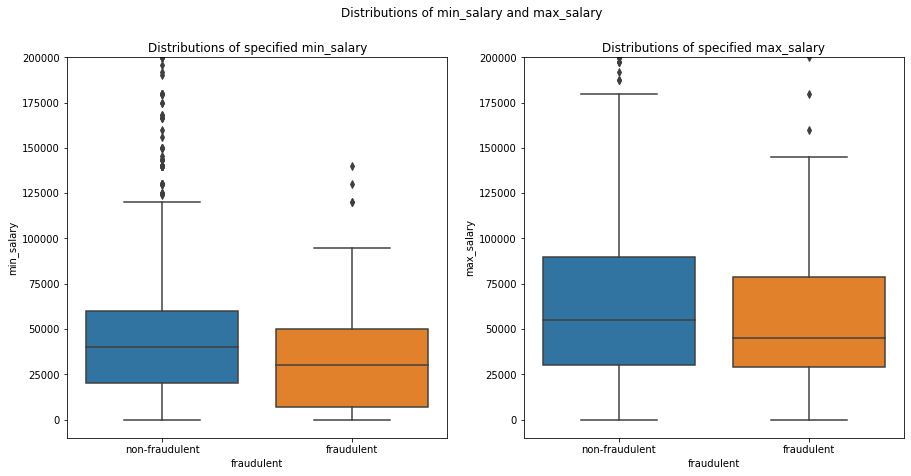

In [43]:
salary =['min_salary','max_salary']
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, feature_name in enumerate(salary):
    sns.boxplot(y=feature_name, x='fraudulent', data=df[df.salary_specified == 1], ax=axes[i])
    axes[i].set_ylim([-1e4, 2e5])
    axes[i].set_xticklabels(['non-fraudulent', 'fraudulent'])
    axes[i].set_title(f'Distributions of specified {feature_name}')

fig.suptitle('Distributions of min_salary and max_salary')
fig.show()

Можно заметить странный факт,что нереальные вакансии обычно предлагают меньшую заработную плату

In [37]:
#создам новый признак - разница между макс и мин зарплатой
df['delta_salary'] = df['max_salary'] - df['min_salary']
num_cols = ['delta_salary']

**Location**

В основном наш признак содержит информацию о стране,штате и городе. Попробую извлечь эту информацию в отдельные колонки (в дальнейшем категориальные)

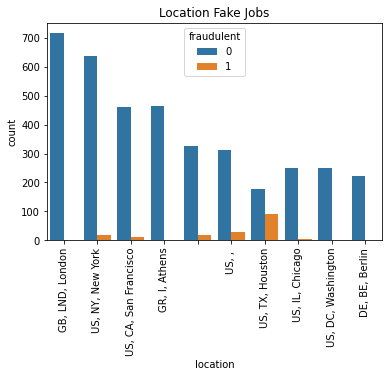

In [45]:
sns.countplot(x=df['location'],data=df, hue="fraudulent",
              order=df['location'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
title = df['location'] + ' fake job count'
plt.title('Location Fake Jobs')
plt.show()

Посмотрев на график происхождения фейковых работ,можно сделать вывод ,что в основном они в США, а это значит, что в Европейских странах это встречается реже

In [38]:
splitted_location = list(df['location'].str.split(', ').values)
splitted_location[:5]

[['US', 'NY', 'New York'],
 ['NZ', '', 'Auckland'],
 ['US', 'IA', 'Wever'],
 ['US', 'DC', 'Washington'],
 ['US', 'FL', 'Fort Worth']]

In [39]:
#Заполню пропуски -'Unpecified'
for l_ind, l in enumerate(splitted_location):
    if l is np.nan:
        splitted_location[l_ind] = ['Unpecified'] * 3
    else:
        for el_ind, el in enumerate(l):
            if el == '':
                l[el_ind] = 'Unpecified'
splitted_location[15:20]

[['SG', '01', 'Singapore'],
 ['IL', 'Unpecified', 'Tel Aviv', 'Israel'],
 ['GB', 'SOS', 'Southend-on-Sea'],
 ['US', 'NY', 'New York'],
 ['US', 'PA', 'USA Northeast']]

Но в некоторых странах есть и по 4 значения,и меньше 3. Попробую исправить это

In [40]:
splitted_location = list(map(lambda l: list(l), splitted_location))

for l_ind, l in enumerate(splitted_location):
    if len(l) > 3:
        splitted_location[l_ind] = l[:2] + [', '.join(l[2:])]
    if len(l) < 3:
        splitted_location[l_ind] += ['Unpecified'] * 2

In [41]:
#Проверю,есть ли еще ошибочные значения
any([len(loc) != 3 for loc in splitted_location])

False

In [42]:
df_location = pd.DataFrame(splitted_location, columns=['country', 'state', 'city'])
df_location.head(5)

,country,state,city
0,US,NY,New York
1,NZ,Unpecified,Auckland
2,US,IA,Wever
3,US,DC,Washington
4,US,FL,Fort Worth


Добавлю эти три новые извлеченные признаки к общему датасету и удалю 'location'

In [43]:
df['country'] = df_location['country']
df['state'] = df_location['state']
df['city'] = df_location['city']

cat_cols += ['country', 'state', 'city']
df.drop('location', axis=1, inplace=True)

In [53]:
#попробуйю удалить признак и посмотреть на точность
X = df.drop(['fraudulent'], axis=1).fillna(0).values
y = df['fraudulent']
cat_features = [8,9,10,11,12,17,18,19]
text_features = list(range(0, 6))
Catboostcl(X,y,cat_features,text_features)

MEAN F1: 42.86%


Похоже,что этот признак действительно сильно влияет. Думаю,стоит удалить его,так как видна зависимость. Возможно этот признак и является утечкой данных  и в нем находится достаточно много информации о целевой переменной

**Label Encoding and OneHotEncoding**

In [44]:
#признаки с большим количеством значений преобразую с помощью  LabelEncoder()
others_cols = ['department','industry','function','country','state','city']
le = LabelEncoder()
for col in others_cols:
    df[col] = le.fit_transform(df[col])

Посмотрим на матрицу корреляций признаков


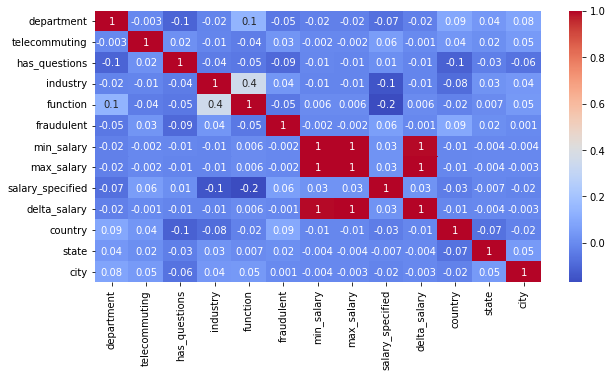

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.heatmap(df.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

по матрице видим корреляцию между признаками 'delta_salary','min_salary' и 'max_salary'. Думаю,что стоит оставить только 'delta_salary'

In [46]:
df.drop(['min_salary','max_salary'], axis=1, inplace=True)

In [47]:
# реализую OneHotEncoding для категориальных признаков у которых не очень много значений
df = pd.get_dummies(df, columns = ['employment_type','required_experience','required_education'])

Теперь сравню метрику после удаления признака 'benefits',который достаточно сильно влияет на целевую переменную

In [58]:
#попробуйю удалить признак и посмотреть на точность
X = df.drop(['fraudulent','benefits'], axis=1).fillna(0).values
y = df['fraudulent']
cat_features = []
text_features = [0,2,3,4]
Catboostcl(X,y,cat_features,text_features)

MEAN F1: 60.20%


In [59]:
#попробуйю без удаления посмотреть на точность
X = df.drop(['fraudulent'], axis=1).fillna(0).values
y = df['fraudulent']
cat_features = []
text_features = [0,2,3,4,5]
Catboostcl(X,y,cat_features,text_features)

MEAN F1: 60.25%


точность практически не отличается,оставляю 'benefits'

**fraudulent**

Рассмотрю теперь целевую переменную

In [60]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

Общее количество поддельных и реальных вакансий:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 1.0, 'Real & Fradulent')

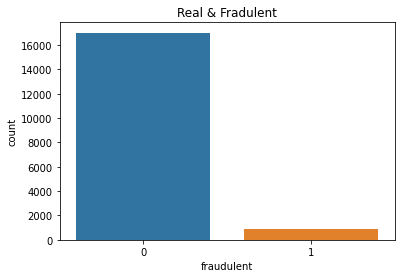

In [61]:
sns.countplot(df.fraudulent).set_title('Real & Fradulent')

Значение 0 явно преобладает и заметна несбалансированность в выборке. В таком случае модель склонна переобучаться.
Поэтому применяю sample_weight при обучении модели, чтобы сгладить эту разницу

**Text columns**

Объединим все признаки с текстом в один:

In [48]:
df['text'] = df[['title','company_profile','description','requirements',
                'benefits']].astype('str').apply(lambda x: ' '.join(x), axis = 1) 

df.drop(['title','company_profile','description',
                 'requirements','benefits'], axis=1, inplace=True)

Гистограмма, описывающая количество символов. Попробуем визуализировать разницу в количестве символов в описании вакансии между реальными и поддельными публикациями:

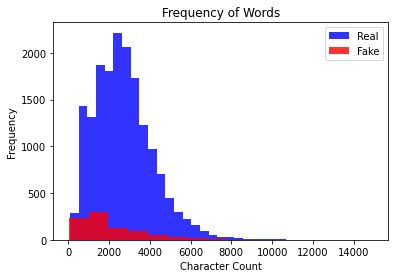

In [49]:
df['character_count'] = df.text.apply(len)

df[df.fraudulent==0].character_count.plot(bins=35, kind='hist', color='blue', 
                                       label='Real', alpha=0.8)
df[df.fraudulent==1].character_count.plot(kind='hist', color='red', 
                                       label='Fake', alpha=0.8)
plt.legend()
plt.title('Frequency of Words')
plt.xlabel("Character Count")
num_cols += ['character_count']

Можно увидеть, что, хоть количество символов относительно одинаково как для реальных, так и для поддельных публикаций, однако реальные вакансии имеют большее количество символов в описании. Можно подтвердить ранее упомянутое,что мошенники не особо вдаются в подробности вакансии

In [50]:
# Проведу очистку текста,токеннизацию и удаление stopwords
# Удалю лишние символы, от них не ожидается никакой предсказательной силы, а просто принесут в текст шум. 
def clean_text(text, ):
    if text is not None:
        text = re.sub(r'[0-9]+','',text)
        text =  text.lower()
        text = re.sub('re:', '', text)
        text = re.sub('-', '', text)
        text = re.sub('_', '', text)
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE)
# Remove text between square brackets
        text =re.sub('\[[^]]*\]', '', text)
# removes punctuation
        text = re.sub(r'[^\w\s]','',text)
        text = re.sub(r'\n',' ',text)
        text = re.sub(r'[0-9]+','',text)
# strip html 
        p = re.compile(r'<.*?>')
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"I'm", "I am", text)
        text = re.sub(r" m ", " am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)

        text = p.sub('', text)

        def tokenize_text(text,tokenizer=default_tokenizer):
            token = default_tokenizer.tokenize(text)
            return token
        
        def remove_stopwords(text, stop_words=default_stopwords):
            tokens = [w for w in tokenize_text(text) if w not in stop_words]
            return ' '.join(tokens)

        def stem_text(text, stemmer=default_stemmer):
            tokens = tokenize_text(text)
            return ' '.join([stemmer.stem(t) for t in tokens])

        text = stem_text(text) # stemming
        text = remove_stopwords(text) # remove stopwords

        return text
    
df['text'] = df['text'].apply(clean_text)
df['text'].head()

0    market intern food weve creat groundbreak awar...
1    custom servic cloud video product second world...
2    commiss machineri assist cma valor servic prov...
3    account execut washington dc passion improv qu...
4    bill review manag spotsourc solut llc global h...
Name: text, dtype: object

In [51]:
# В последствии отдельная токенизация не понадобилась, 
# так как будет использоваться встроенный токенизатор BERTа
text = df['text'].copy()

In [52]:
# Векторизую очищенный текст в матрицу tfidf со всеми словами с помощью TfidfVectorizer
# Этот метод будет подсчитывать важность слов в документе и редкость самого слова.
cv = TfidfVectorizer(max_features = 100) 
x = cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names()) 
df.drop(["text"], axis=1, inplace=True)
main_df = pd.concat([df1,df], axis=1) # соединю с оставшимися признаками 

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [67]:
main_df.head()

,abil,account,also,amp,applic,base,benefit,best,build,busi,candid,client,commun,compani,creat,creativ,custom,data,deliv,design,develop,digit,employ,employe,engin,ensur,environ,excel,experi,get,great,grow,ha,help,high,includ,industri,innov,intern,job,knowledg,lead,learn,level,like,look,make,manag,market,mobil,must,need,new,offer,offic,one,oper,opportun,part,peopl,perform,person,plan,posit,process,product,profession,program,project,provid,qualiti,requir,respons,role,sale,servic,skill,softwar,solut,strong,success,support,system,team,technic,technolog,test,thi,time,train,understand,us,use,want,web,well,within,work,world,year,department,telecommuting,has_questions,industry,function,fraudulent,salary_specified,delta_salary,country,state,city,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_Unspecified,required_experience_Associate,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_Unspecified,required_education_Associate Degree,required_education_Bachelor's Degree,required_education_Certification,required_education_Doctorate,required_education_High School or equivalent,required_education_Master's Degree,required_education_Professional,required_education_Some College Coursework Completed,required_education_Some High School Coursework,required_education_Unspecified,required_education_Vocational,required_education_Vocational - Degree,required_education_Vocational - HS Diploma,character_count
0,0.000000,0.000000,0.122895,0.108523,0.000000,0.000000,0.000000,0.126546,0.000000,0.096202,0.000000,0.000000,0.179553,0.080675,0.124437,0.000000,0.000000,0.0,0.000000,0.0,0.179553,0.0,0.000000,0.0,0.130900,0.000000,0.000000,0.000000,0.068507,0.000000,0.000000,0.000000,0.249403,0.000000,0.000000,0.000000,0.000000,0.000000,0.270696,0.000000,0.000000,0.000000,0.00000,0.000000,0.278226,0.000000,0.000000,0.174128,0.35658,0.0,0.000000,0.108404,0.391929,0.118783,0.119592,0.122221,0.000000,0.000000,0.000000,0.112996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115671,0.143104,0.000000,0.000000,0.000000,0.000000,0.114128,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.224792,0.132681,0.153567,0.0,0.113620,0.000000,0.000000,0.097785,0.00000,0.000000,0.000000,0.108787,0.0,0.000000,0.000000,0.000000,0.273511,0.000000,0.000000,758,0,0,123,22,0,0,0,86,227,1457,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2663
1,0.000000,0.041676,0.033662,0.059451,0.000000,0.061661,0.000000,0.000000,0.000000,0.105402,0.030751,0.119472,0.098363,0.044195,0.000000,0.039839,0.135615,0.0,0.071496,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.030859,0.098448,0.112588,0.216858,0.107584,0.125848,0.136628,0.000000,0.067409,0.187275,0.000000,0.037140,0.074146,0.000000,0.031445,0.000000,0.03593,0.035275,0.000000,0.027138,0.063312,0.357714,0.00000,0.0,0.000000,0.029693,0.000000,0.000000,0.098272,0.066955,0.000000,0.028723,0.035009,0.000000,0.000000,0.035191,0.035284,0.056370,0.064358,0.425025,0.063367,0.000000,0.330143,0.024485,0.069115,0.000000,0.031261,0.17805,0.000000,0.224590,0.024171,0.036153,0.000000,0.000000,0.158021,0.000000,0.036343,0.105159,0.0,0.000000,0.000000,0.101393,0.026784,0.00000,0.066805,0.028613,0.029798,0.0,0.038078,0.000000,0.000000,0.168564,0.363728,0.000000,1161,0,0,75,7,0,0,0,61,293,188,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6133
2,0.000000,0.000000,0.000000,0.092739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.191878,0.279550,0.000000,0.206823,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.502056,0.0,0.223721,0.109500,0.000000,0.000000,0.058543,0.112760,0.000000,0.000000,0.106564,0.000000,0.000000,0.000000,0.104227,0.000000,0.115662,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.148801,0.00000,0.0,0.1163

**Normalization**

In [53]:
#Применю StandardScaler для нормализации числовых признаков 
num_cols_std = StandardScaler().fit_transform(main_df[num_cols].values)
main_df[num_cols] = num_cols_std

# Model

**CatBoostClassifier**

In [65]:
X = main_df.drop(['fraudulent'], axis=1).values
y = main_df['fraudulent']
cv = KFold(n_splits = 5, random_state=42, shuffle=True)

scores = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Сбалансирую таргет:
    smk  = SMOTETomek(random_state=42)
    X_train,y_train = smk.fit_resample(X_train,y_train)

    model = CatBoostClassifier(iterations=200,
                            verbose=False,
                            loss_function='Logloss',
                            eval_metric = 'F1',
                            ).fit(X_train, y_train, eval_set=(X_test, y_test), 
                            # sample_weight=sample_weight,
                            use_best_model=True,)

  # сделаем предсказание
    preds = model.predict(X_test)
    score = f1_score(y_test, preds)
    scores.append(score)
# оценим итоги. Взглянем на усредненное значение метрики по блокам
print(f'MEAN F1: {np.mean(scores) * 100:.2f}%')
print(f"CatBoost classification report:\n {classification_report(y_test, preds)}")

MEAN F1: 75.69%
CatBoost classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3398
           1       0.83      0.62      0.71       178

    accuracy                           0.97      3576
   macro avg       0.90      0.81      0.85      3576
weighted avg       0.97      0.97      0.97      3576



0.9745525727069351


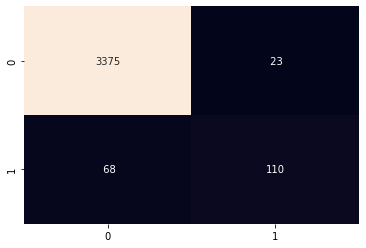

In [66]:
print(accuracy_score(preds,y_test))
sns.heatmap(confusion_matrix(y_test,preds), annot=True,fmt='3g', cbar=False)
plt.show()

провела эксперименты с удалением самого влиятельного признака 'has_company_logo' и решила его удалить. Метрика улучшилась! (без удаления около 60%)

Попробую применить другие базовые модели и посмотреть на точность классификации

In [71]:
def modeling(rf,gb,knn):
  X = main_df.drop(['fraudulent'], axis=1).values
  y = main_df['fraudulent']
  cv = KFold(n_splits = 5, random_state=42, shuffle=True)

  scores1 = []
  scores2 = []
  scores3 = []
  for train_index, test_index in cv.split(X):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      #Сбалансирую таргет:
      smk  = SMOTETomek(random_state=42)
      X_train,y_train = smk.fit_resample(X_train,y_train)

      rf.fit(X_train,y_train)
      gb.fit(X_train, y_train)
      knn.fit(X_train,y_train)
    # сделаем предсказание
      preds1 = rf.predict(X_test)
      preds2 = gb.predict(X_test)
      preds3 = knn.predict(X_test)

      score1 = f1_score(y_test, preds1)
      score2 = f1_score(y_test, preds2)
      score3 = f1_score(y_test, preds3)
      scores1.append(score1)
      scores2.append(score2)
      scores3.append(score3)
  # оценим итоги. Взглянем на усредненное значение метрики по блокам
  print(f'MEAN F1-rf: {np.mean(scores1) * 100:.2f}%')
  print(f'MEAN F1-gb: {np.mean(scores2) * 100:.2f}%')
  print(f'MEAN F1-knn: {np.mean(scores3) * 100:.2f}%')

In [72]:
rf=RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy").fit(X_train,y_train)
gb=GradientBoostingClassifier().fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
modeling(rf,gb,knn)

MEAN F1-rf: 71.90%
MEAN F1-gb: 59.11%
MEAN F1-knn: 38.57%


Попробую применить наиболее частую реализацию бустинга - алгоритм AdaBoost. Это мета-алгоритм, который в процессе обучения строит композицию из базовых алгоритмов обучения для улучшения их эффективности

In [73]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf.fit(X_train,y_train)

clf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [74]:
print(clf.score(X_test,y_test))
print(classification_report(y_test, clf.predict(X_test)))

0.935682326621924
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3398
           1       0.40      0.57      0.47       178

    accuracy                           0.94      3576
   macro avg       0.69      0.76      0.72      3576
weighted avg       0.95      0.94      0.94      3576



Попробую подобрать параметры:

In [75]:
# from sklearn.model_selection import GridSearchCV
# parameters={
#     'max_depth': [10,40,None],
#     'n_estimators': [50, 100,200],
#     'min_samples_leaf': [1, 4],
#     'min_samples_split': [2,20,50,150,200,400,600]
# }

# model = GradientBoostingClassifier()
# model.fit(X_train, y_train)

# clf = GridSearchCV(model, parameters,cv=5)

# clf.fit(X_train, y_train)

# #     best_max_depth = best_model.best_estimator_.get_params()['max_depth']
# #     best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

# print(clf.best_params_)

Закомментирую,тк очень долго работает

In [76]:
gb=GradientBoostingClassifier(min_samples_split=200,max_depth=10).fit(X_train, y_train)  
print(f"Gradient Boost train accuracy: {accuracy_score(gb.predict(X_train),y_train)}")
print(f"Gradient Boost test accuracy: {accuracy_score(gb.predict(X_test),y_test)}")
print(f"Gradient Boost classification report:\n {classification_report(y_test, gb.predict(X_test))}")

Gradient Boost train accuracy: 1.0
Gradient Boost test accuracy: 0.9793064876957495
Gradient Boost classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3398
           1       0.92      0.64      0.75       178

    accuracy                           0.98      3576
   macro avg       0.95      0.82      0.87      3576
weighted avg       0.98      0.98      0.98      3576



С подбором параметров достигли более лучших результатов

**Bi-Directional LSTM**

In [ ]:
#Очистку текста я уже проводила,поэтому сразу использую веторизацию с помощью one-hot

voc_size=5000
onehot_text=[one_hot(words,voc_size)for words in text] 
onehot_text[0]

In [55]:
sent_length=100
sent_with_same_lenght = pad_sequences(onehot_text,padding='post',maxlen=sent_length)
print(sent_with_same_lenght)

[[ 718  656 3179 ... 3914 1560 2859]
 [4660 3914 3519 ...  737 1966 4351]
 [4554 1607 2776 ... 4444  341 3356]
 ...
 [1133 1141  341 ... 3567  106  654]
 [3246 1956 1920 ... 2772  720 3868]
 [1386 1043 3095 ... 2378 2078 2145]]


In [56]:
#  Строим модель
embedding_vector_features=80
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(150))) #двунаправленный LSTM:будет запускать входные данные 
                                     #двумя способами: один из прошлого в будущее и один из будущего в прошлое
model1.add(Dropout(0.4))
model1.add(Dense(1,activation='sigmoid')) 
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 80)           400000    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              277200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 677,501
Trainable params: 677,501
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
len(sent_with_same_lenght),df['fraudulent'].shape

(17880, (17880,))

In [58]:
X = np.array(sent_with_same_lenght)
y = np.array(df['fraudulent'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    shuffle=True, random_state=RANDOM_SEED)

In [59]:
#oversampling для балансировки данных целевой переменной
smk  = SMOTETomek(random_state=42)
X_train,y_train = smk.fit_resample(X_train,y_train)

In [60]:
# обучаем модель:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=64)

Epoch 1/15
399/399 [==============================] - 29s 55ms/step - loss: 0.1614 - accuracy: 0.9520 - val_loss: 0.1246 - val_accuracy: 0.9667
Epoch 2/15
399/399 [==============================] - 20s 51ms/step - loss: 0.0710 - accuracy: 0.9824 - val_loss: 0.1243 - val_accuracy: 0.9682
Epoch 3/15
399/399 [==============================] - 20s 51ms/step - loss: 0.0731 - accuracy: 0.9792 - val_loss: 0.1351 - val_accuracy: 0.9655
Epoch 4/15
399/399 [==============================] - 20s 51ms/step - loss: 0.0621 - accuracy: 0.9828 - val_loss: 0.1330 - val_accuracy: 0.9617
Epoch 5/15
399/399 [==============================] - 20s 51ms/step - loss: 0.0396 - accuracy: 0.9884 - val_loss: 0.1015 - val_accuracy: 0.9682
Epoch 6/15
399/399 [==============================] - 20s 51ms/step - loss: 0.0214 - accuracy: 0.9934 - val_loss: 0.1157 - val_accuracy: 0.9662
Epoch 7/15
399/399 [==============================] - 20s 51ms/step - loss: 0.0130 - accuracy: 0.9963 - val_loss: 0.1139 - val_accuracy:

In [61]:
y_pred=model1.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [62]:
print(f"accuracy_score:\n {accuracy_score(y_test,y_pred)}")
print(f"BiRNN:\n {classification_report(y_test,y_pred)}")

accuracy_score:
 0.9736017897091722
BiRNN:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4247
           1       0.80      0.63      0.70       223

    accuracy                           0.97      4470
   macro avg       0.89      0.81      0.84      4470
weighted avg       0.97      0.97      0.97      4470



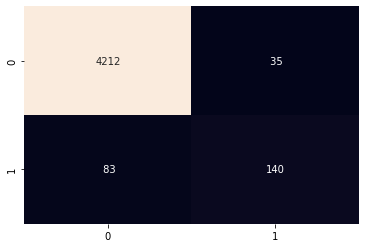

In [63]:
from sklearn.metrics import plot_confusion_matrix
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='3g', cbar=False)
plt.show()

Решила попробовать использовать "Двунаправленные LSTM" и результат очень даже неплохой,метрика F1 - 84%. Bidirectional LSTM представляет собой две однонаправленные рекуррентные сети, одна из которых обрабатывает входную последовательность в прямом порядке, а другая — в обратном.Благодаря данной архитектуре сети доступна информация о контексте как из прошлого, так и из будущего, что решает проблему однонаправленных рекуррентных сетей. Для обучения biRNN используются те же алгоритмы, что и для RNN.

**Выводы:**

В результате анализа, мы можем обоснованно распознать, является ли вакансия мошеннической, используя несколько особенностей, основанных на анализе информации: 
1. мошеннические вакансии обычно не имеют корпоративного логотипа;
2. не добавляют проверочные вопросы; 
3. обычно упоминают информацию о зарплате даже в названии, чтобы заманить кандидатов;
4. могут пропустить определенные атрибуты работы (например, отрасль, должность, уровень образования кандидата,и уровень опыта)

Модели так же предполагают, что профиль компании является не самой сильной стороной, существуют и другие полезные функции, такие как описание должности, требования и бонусы, которые также обладают хорошей предсказательной силой.

Проведена вся необходимая работа по подготовке данных, их анализ, извлечение информации, обработка и подготовка для дальнейшей работы. Создан бейзлайн, по которому сравнивались изменения в датасете. Датасет проверен на дубликаты и выбросы, выполнена нормализация, использовались классические методы кодирования категориальных признаков. Подготовлены дополнительные признаки. По итогам анализа, из некоторых признаков были извлечены более полезная информация, и далее изначальные удалены. Использовались классические методы обработки языка,а именно очистка текста. В модели применялась токенизация и лемматизация.


 Я убедилась, что с помощью базовых моделей, можно получить хорошую предсказательную силу, применив NLP, поработав с обработкой текста. С базовыми моделями, основанными на NLP, мы получаем очень хорошую точность - av.F1 - 85%  с минимальной настройкой гиперпараметров. С более сложными моделями, такими как  "Двунаправленные LSTM" по-прежнему получаем хороший результат и неплохую классификацию по confusion matrix.